# Evaluate model

In [1]:
from dataset import DwgDataset
from sketch_rnn import Trainer
from IPython.display import clear_output
from plot_graphics import plot_history
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import PIL
import imageio
import glob
import os

Could not import drawSvg


In [2]:

dwg_dataset = DwgDataset(pickle_file='test_dataset_groups.pickle', batch_size=1, limit_seq_len=5000)
trainer = Trainer(dwg_dataset, preload_model=True)

trainer.encoder.eval()
trainer.decoder.eval()


C:\Users\mihanick.MCAD\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


DecoderRNN(
  (fc_hc): Linear(in_features=64, out_features=1024, bias=True)
  (lstm): LSTM(69, 512, dropout=0.45)
  (fc_params): Linear(in_features=512, out_features=123, bias=True)
)

In [3]:
# use imageio to create animated gif using images 

def create_gif_from_frames(folder):
    '''
    creates gif file from png frames in folder
    frames should be named 'gen_frame*.png'
    png frames are erased in process
    
    uses
     imageio
     os
     glob
    '''

    anim_file = folder+ '/predictions.gif'

    with imageio.get_writer(anim_file, mode = 'I', fps=2) as writer:
        filenames = glob.glob(folder+'/gen_frame*.png')
        filenames = sorted(filenames)

        last = -1

        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if (round(frame)> round(last)):
                last = frame
            else:
                continue

            image = imageio.imread(filename)
            writer.append_data(image)
        return anim_file

tensor([[-0.0054,  0.0470,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.0422, -0.0150,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.0507, -0.0427,  0.0000,  0.0000,  1.0000]])
tensor([[-0.1506,  0.2565,  0.0000,  0.0000,  1.0000]])
tensor([[0.0501, 0.3360, 0.0000, 0.0000, 1.0000]])
tensor([[-0.0737, -0.0048,  0.0000,  0.0000,  1.0000]])
tensor([[0.1940, 0.0164, 0.0000, 0.0000, 1.0000]])
tensor([[0.0333, 0.0715, 0.0000, 0.0000, 1.0000]])
tensor([[-0.4191, -0.4397,  0.0000,  0.0000,  1.0000]])
tensor([[-0.0871, -0.0040,  0.0000,  0.0000,  1.0000]])
tensor([[-0.0312, -0.0432,  0.0000,  0.0000,  1.0000]])
tensor([[0.4670, 0.1792, 0.0000, 1.0000, 0.0000]])
tensor([[0.0420, 0.0951, 0.0000, 0.0000, 1.0000]])
tensor([[0.1070, 0.2013, 0.0000, 0.0000, 1.0000]])
tensor([[-0.3425, -0.0705,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.0738, -0.0270,  0.0000,  0.0000,  1.0000]])
tensor([[-0.4581, -0.4698,  0.0000,  0.0000,  1.0000]])
tensor([[-0.1384,  0.0248,  0.0000,  0.0000,  1.0000]])
tensor([[-0.1626,  0.3

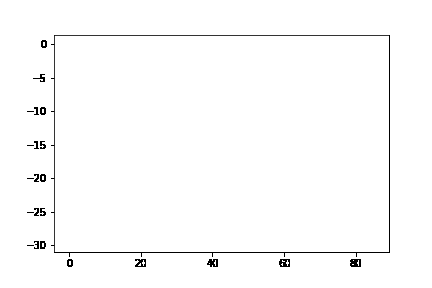

In [4]:
torch.set_printoptions(profile="full")
def plot_generated_stroke_over_sequence(sequence, stroke=None, batch_number=0):
    # print(sequence.shape, stroke)
    
    if stroke is not None:
        sequence = torch.cat([sequence.detach().cpu(), stroke.unsqueeze(0)], dim=0)
        
    sequence = sequence[:,batch_number,:].numpy()
    sequence = sequence[sequence[:, 4] < 1]
    # print(sequence)
    x_sample = 100*np.cumsum(sequence[:,0], 0)
    y_sample = 100*np.cumsum(sequence[:,1], 0)
    p1 = np.array(sequence[:,2])
    p2 = np.array(sequence[:,3])
    p3 = np.array(sequence[:,4])
    
    sequence = np.stack([x_sample,y_sample,p1,p2,p3], axis=1)

    strokes = np.split(sequence, np.where(sequence[:,2]>0)[0]+1)
    
    fig = plt.figure()
    for i in range(len(strokes)):
        s=strokes[i]
        cl = 'black'
        if i == len(strokes) - 1:
            cl='red'
        plt.plot(s[:,0],-s[:,1], color=cl)
        
    return fig

import shutil
folder = 'img_g'

if os.path.exists(folder):
    shutil.rmtree(folder)
os.mkdir(folder)

_, b = next(enumerate(dwg_dataset.train_loader))
input_seq, mask = b
input_seq = input_seq.to(trainer.device).transpose(0,1)

for i in range(1, trainer.max_seq_length):
    
    # print(i)
    seq_so_far = torch.zeros_like(input_seq)
    seq_so_far[:i+1,:,:] = input_seq[:i+1,:,: ]

    if seq_so_far[i,0,4]==1:
        continue

    #print(i, seq_so_far[:10])
    #print(seq_so_far.shape)
    z, _, _ = trainer.encoder(seq_so_far)

    # expand z in order it to be able to concatenate with inputs
    z_stack = torch.stack([z] * (trainer.max_seq_length))

    # inputs is the concatination of z and batch_inputs:
    inputs = torch.cat([seq_so_far, z_stack], 2)

    pi, mu_x, mu_y, sigma_x, sigma_y, rho_xy, q, _, _ = trainer.decoder(inputs, z)

    generated_stroke = trainer.sample_next_state(pi, q, mu_x, mu_y, sigma_x, sigma_y, rho_xy)
    print(generated_stroke)
    #clear_output()
    graph = plot_generated_stroke_over_sequence(seq_so_far, generated_stroke, 0)
    #display(graph)
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(),
                 canvas.tostring_rgb())
    name = folder + '/gen_frame'+'{0:04d}'.format(i)+'.png'
    pil_image.save(name,"PNG")
    plt.close("all")

    
import IPython
from IPython.display import Image

img_gif = create_gif_from_frames(folder)
Image(filename=img_gif)